In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap
import numba

C:\Users\USER\anaconda3\envs\stroke_vitalsing\lib\site-packages\umap\__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


In [4]:
tidy_data = pd.read_csv(os.path.join('..', 'data','tidy_Stroke_Vital_Sign.csv'))
print(tidy_data.shape)
X_data = tidy_data.drop(['UID', 'Hospital_ID', 'admission_date', 'discharge_date',
                         'Mortality', 'CVDeath', 'death_date', 'SurvivalWeeks'], axis=1)
y_data = tidy_data[['SurvivalWeeks']]
y_data = (y_data < 24).astype(int)

(13623, 51)


In [5]:
# remove constant features
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0)
selector.fit(X_data)
X_data = X_data[X_data.columns[selector.get_support(indices=True)]]

In [7]:
X_data.columns.values

array(['Sex', 'Age', 'AF', 'DM', 'HTN', 'Hyperlipidemia', 'CHF',
       'Smoking', 'Cancer before adm', 'ALT', 'CHOL', 'TG', 'E', 'V', 'M',
       'Foley', 'NG', 'ICU', 'MPsum', 'Mean HR', 'MeanHR G', 'HR SD',
       'HRSD G', 'HR CV', 'HRCV G', 'Mean SBP', 'Mean SBP G', 'SBP SD',
       'SBPSD G', 'SBP CV', 'SBPCV G', 'Mean DBP', 'MeanDBP G', 'DBP SD',
       'DBPSD G', 'DBP CV', 'DBPCV G', 'Mean RR', 'MeanRR G', 'RR SD',
       'RRSD G', 'RR CV', 'RRCV G'], dtype=object)

In [8]:
categorical_ix = np.array([0, 2, 3, 4, 5, 6, 7, 8, 15, 17])
categorical_columns = X_data.columns[categorical_ix].values
numerical_columns = np.setdiff1d(X_data.columns, categorical_columns)
numerical_ix = np.array([X_data.columns.get_loc(c) for c in numerical_columns])

In [9]:
print(X_data.head())
print(categorical_columns)
print(numerical_columns)

   Sex   Age   AF   DM  HTN  Hyperlipidemia  CHF  Smoking  Cancer before adm  \
0  1.0  62.0  0.0  1.0  0.0             0.0  0.0      1.0                0.0   
1  1.0  81.0  1.0  0.0  1.0             1.0  0.0      0.0                1.0   
2  0.0  80.0  0.0  1.0  0.0             1.0  0.0      0.0                0.0   
3  1.0  82.0  0.0  1.0  1.0             0.0  0.0      1.0                0.0   
4  1.0  89.0  0.0  0.0  1.0             0.0  0.0      0.0                0.0   

    ALT  ...     DBP SD  DBPSD G    DBP CV  DBPCV G    Mean RR  MeanRR G  \
0  21.0  ...   7.148569      2.0  0.094773      3.0  16.285714       2.0   
1  17.0  ...   8.436824      3.0  0.096783      3.0  16.500000       2.0   
2  42.0  ...   7.442819      2.0  0.070839      2.0  17.454545       3.0   
3  36.0  ...   7.336774      2.0  0.098515      3.0  18.333333       4.0   
4  23.0  ...  12.493529      4.0  0.162173      5.0  17.848101       3.0   

      RR SD  RRSD G     RR CV  RRCV G  
0  1.277753     2.0  0

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X_data[numerical_columns] = StandardScaler().fit_transform(X_data[numerical_columns])
# one-hot
X_data_one_hot = pd.get_dummies(X_data, columns=categorical_columns)
print(X_data.head())

   Sex       Age   AF   DM  HTN  Hyperlipidemia  CHF  Smoking  \
0  1.0 -0.380630  0.0  1.0  0.0             0.0  0.0      1.0   
1  1.0  1.095454  1.0  0.0  1.0             1.0  0.0      0.0   
2  0.0  1.017765  0.0  1.0  0.0             1.0  0.0      0.0   
3  1.0  1.173142  0.0  1.0  1.0             0.0  0.0      1.0   
4  1.0  1.716963  0.0  0.0  1.0             0.0  0.0      0.0   

   Cancer before adm       ALT  ...    DBP SD   DBPSD G    DBP CV   DBPCV G  \
0                0.0 -0.213204  ... -0.775208 -1.096798 -0.437271 -0.271625   
1                1.0 -0.369167  ... -0.325353  0.207469 -0.381788 -0.271625   
2                0.0  0.605606  ... -0.672457 -1.096798 -1.097912 -1.409145   
3                0.0  0.371660  ... -0.709487 -1.096798 -0.333973 -0.271625   
4                0.0 -0.135222  ...  1.091235  1.511735  1.423168  2.003414   

    Mean RR  MeanRR G     RR SD    RRSD G     RR CV    RRCV G  
0 -1.055306 -1.074712 -0.200006  0.123164 -0.039006 -0.547869  
1 -0.8

In [11]:
norm_range = np.array(np.nanmax(X_data.values, axis=0) - np.nanmin(X_data.values, axis=0))

# customised distance function

In [12]:
@numba.njit()
def heom(x, y):
    results_array = np.zeros(x.shape)
    results_array[categorical_ix] = np.not_equal(x[categorical_ix], y[categorical_ix]) * 1  # use "* 1" to convert it into int
    results_array[numerical_ix] = np.abs(x[numerical_ix] - y[numerical_ix]) / norm_range[numerical_ix]
    return np.sum(np.square(results_array))

# UMAP-myHEOM

C:\Users\USER\anaconda3\envs\stroke_vitalsing\lib\site-packages\umap\umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


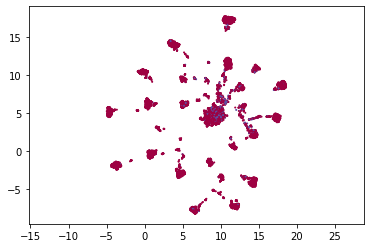

In [13]:
reducer = umap.UMAP(metric=heom, random_state=369)

umap_heom_embedding = reducer.fit_transform(X_data)

plt.clf()
plt.scatter(
    umap_heom_embedding[:, 0],
    umap_heom_embedding[:, 1],
    c=y_data.values.astype(int), s=1, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')

# UMAP-cosine

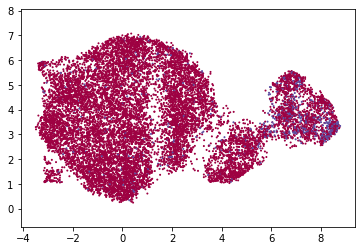

In [14]:
reducer = umap.UMAP(metric='cosine', random_state=369)

umap_cos_embedding = reducer.fit_transform(X_data_one_hot)

plt.clf()
plt.scatter(
    umap_cos_embedding[:, 0],
    umap_cos_embedding[:, 1],
    c=y_data.values.astype(int), s=1, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')

## Add cluster labels

In [15]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan, DBSCAN, MiniBatchKMeans
# 需要繼續調參增加類別，有兩個方向都是可以的，一個是繼續減少eps，另一個是增加min_samples
import hdbscan
# conda install -c conda-forge hdbscan

ModuleNotFoundError: No module named 'hdbscan'

In [ ]:
umap_cluster = hdbscan.HDBSCAN(
    min_samples=50,
    min_cluster_size=2,
    cluster_selection_epsilon=0.5
).fit(umap_cos_embedding)

plt.clf()
plt.scatter(umap_cos_embedding[:, 0],
            umap_cos_embedding[:, 1],
            c=umap_cluster.labels_,
            s=1,
            cmap='Spectral');
tidy_data['umap_label'] = umap_cluster.labels_
print(len(set(umap_cluster.labels_)))
print(set(umap_cluster.labels_))

In [ ]:
tidy_data.to_csv('vital_sign_cluster.csv', index=False)